# Klasifikasi Citra Penyakit Radang Paru-Paru dan Paru Paru Terindikasi COVID19 Menggunakan Metode CNN

Link Kaggle : https://www.kaggle.com/prashant268/chest-xray-covid19-pneumonia

# Load Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/Colab Notebooks/Kuliah/Semester 7/ML/Tugas_Besar/Modul_4"

In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/Kuliah/Semester 7/ML/Tugas_Besar/Modul_4

/content/drive/MyDrive/Colab Notebooks/Kuliah/Semester 7/ML/Tugas_Besar/Modul_4


In [ ]:
!ls

Data  datasplit  kaggle.json


In [ ]:
#! kaggle datasets download -d prashant268/chest-xray-covid19-pneumonia

100% 2.04G/2.06G [00:23<00:00, 128MB/s]
100% 2.06G/2.06G [00:23<00:00, 94.5MB/s]


In [ ]:
#! unzip \*.zip &> /dev/null && rm *.zip

In [ ]:
!ls Data

test  train


In [ ]:
#!mv Data/test/COVID19/*.jpg covid/

In [ ]:
#!mv Data/test/PNEUMONIA/*.jpg pneumonia/

In [ ]:
#!mv Data/test/NORMAL/*.jpg normal/

In [ ]:
#!mv Data/train/COVID19/*.jpg covid/

In [ ]:
#!mv Data/train/PNEUMONIA/*.jpg pneumonia/

In [ ]:
#!mv Data/train/NORMAL/*.jpg normal/

In [ ]:
!ls Data

test  train


# Splitting Data 2 (Skenario = 0.8, 0.19, 0.1)

In [ ]:
pip install split-folders

In [ ]:
#!mkdir datasplit

In [ ]:
data = "/content/drive/MyDrive/Colab Notebooks/Kuliah/Semester 7/ML/Tugas_Besar/Modul_3/dataset"
split = "/content/drive/MyDrive/Colab Notebooks/Kuliah/Semester 7/ML/Tugas_Besar/Modul_4/datasplit"

In [ ]:
!ls

Data  datasplit  kaggle.json


In [ ]:
#import splitfolders
#splitfolders.ratio(data, output=split, seed=1337, ratio=(0.8, 0.19, 0.01), group_prefix=None)

Copying files: 6432 files [26:18,  4.07 files/s]


In [ ]:
!ls datasplit

test  train  val


In [ ]:
train_path = "/content/drive/MyDrive/Colab Notebooks/Kuliah/Semester 7/ML/Tugas_Besar/Modul_4/datasplit/train"
val_path = "/content/drive/MyDrive/Colab Notebooks/Kuliah/Semester 7/ML/Tugas_Besar/Modul_4/datasplit/val"
test_path = "/content/drive/MyDrive/Colab Notebooks/Kuliah/Semester 7/ML/Tugas_Besar/Modul_4/datasplit/test"

#Preprocessing (Skenario 1)

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import shuffle

Batch_size=32
augmen_gen = ImageDataGenerator(rescale=1. / 255,
                            rotation_range=40,
                            width_shift_range=0.2,
                            height_shift_range=0.2,
                            zoom_range=0.2,
                            horizontal_flip=True,
                            fill_mode='nearest')

train_gen = augmen_gen.flow_from_directory(
    train_path,
    class_mode = 'categorical',
    shuffle=False,
    target_size = (150,150),
    batch_size=Batch_size,
    color_mode ='rgb'
)

val_gen = augmen_gen.flow_from_directory(
    val_path,
    class_mode = 'categorical',
    shuffle=False,
    target_size = (150,150),
    batch_size=Batch_size,
    color_mode ='rgb'
)

test_gen = augmen_gen.flow_from_directory(
    test_path,
    class_mode = 'categorical',
    shuffle=False,
    target_size = (150,150),
    batch_size=Batch_size,
    color_mode ='rgb',
)

Found 5144 images belonging to 3 classes.
Found 1220 images belonging to 3 classes.
Found 68 images belonging to 3 classes.


# Modelling & Plotting (Skenario 6)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Conv2D, MaxPool2D, Flatten, AveragePooling2D, BatchNormalization, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam, SGD
import time

In [ ]:
model = Sequential()

model.add(InputLayer(input_shape=[150,150,3]))

model.add(Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='elu'))
model.add(MaxPool2D(pool_size=2, padding='same'))
model.add(Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='elu'))
model.add(MaxPool2D(pool_size=2, padding='same'))
model.add(Conv2D(filters=128, kernel_size=3, strides=1, padding='same', activation='elu'))
model.add(MaxPool2D(pool_size=2, padding='same'))
model.add(Dropout(0.25))
model.add(BatchNormalization())
model.add(Flatten())

# Fully Connected Layer
model.add(Dense(512, activation='elu'))
model.add(Dropout(0.3))
model.add(Dense(3, activation='softmax'))

In [ ]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 38, 38, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 38, 38, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 19, 19, 128)      0

In [ ]:
model.compile(loss='categorical_crossentropy',
             optimizer=Adam(lr=0.00015, decay=0.00015/32),
             metrics='accuracy')

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
model_1 = model.fit(train_gen, epochs=50, validation_data=val_gen, validation_steps = 4, verbose=1)

Epoch 1/50
161/161 [==============================] - 164s 1s/step - loss: 0.5728 - accuracy: 0.7832 - val_loss: 0.8740 - val_accuracy: 0.7031
Epoch 2/50
161/161 [==============================] - 170s 1s/step - loss: 0.4322 - accuracy: 0.8398 - val_loss: 0.9853 - val_accuracy: 0.8281
Epoch 3/50
161/161 [==============================] - 164s 1s/step - loss: 0.4417 - accuracy: 0.8359 - val_loss: 1.7034 - val_accuracy: 0.4531
Epoch 4/50
161/161 [==============================] - 160s 996ms/step - loss: 0.3981 - accuracy: 0.8577 - val_loss: 2.7550 - val_accuracy: 0.2656
Epoch 5/50
161/161 [==============================] - 159s 986ms/step - loss: 0.3357 - accuracy: 0.8834 - val_loss: 8.9955 - val_accuracy: 0.1484
Epoch 6/50
161/161 [==============================] - 163s 1s/step - loss: 0.2677 - accuracy: 0.9098 - val_loss: 1.8804 - val_accuracy: 0.4531
Epoch 7/50
161/161 [==============================] - 161s 1s/step - loss: 0.3397 - accuracy: 0.8857 - val_loss: 2.4775 - val_accuracy: 

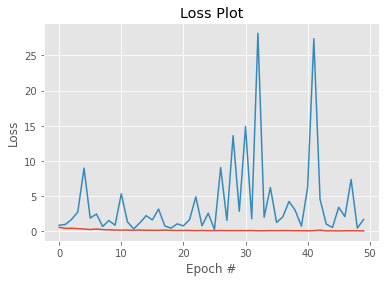

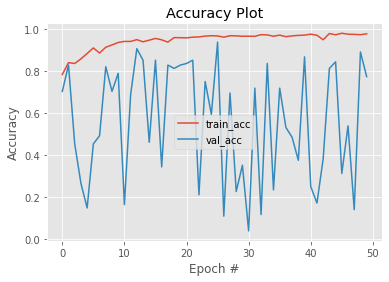

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use("ggplot")

plt.plot(np.arange(0, 50), model_1.history["loss"], label="train_loss")
plt.plot(np.arange(0, 50), model_1.history["val_loss"], label="val_loss")
plt.title("Loss Plot")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.show()

plt.plot(np.arange(0, 50), model_1.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, 50), model_1.history["val_accuracy"], label="val_acc")
plt.title("Accuracy Plot")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import classification_report

pred = model.predict(test_gen)
predictions = np.argmax(pred, axis = 1)
#labels = (pred > 0.5).astype(np.int)
print(classification_report(test_gen.classes,predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       0.00      0.00      0.00        17
           2       0.72      1.00      0.84        44

    accuracy                           0.75        68
   macro avg       0.57      0.67      0.61        68
weighted avg       0.57      0.75      0.65        68



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Modelling & Plotting (Skenario 7)

In [ ]:
model2 = Sequential()

model2.add(InputLayer(input_shape=[150,150,3]))

model2.add(Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='elu'))
model2.add(AveragePooling2D(pool_size=2, padding='same'))

model2.add(Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='elu'))
model2.add(AveragePooling2D(pool_size=2, padding='same'))

model2.add(Conv2D(filters=128, kernel_size=3, strides=1, padding='same', activation='elu'))
model2.add(AveragePooling2D(pool_size=2, padding='same'))

model2.add(Dropout(0.25))
model2.add(BatchNormalization())
model2.add(Flatten())

# Fully Connected Layer
model2.add(Dense(512, activation='elu'))
model2.add(Dropout(0.3))
model2.add(Dense(3, activation='softmax'))

In [ ]:
print(model2.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      896       
                                                                 
 average_pooling2d (AverageP  (None, 75, 75, 32)       0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 average_pooling2d_1 (Averag  (None, 38, 38, 64)       0         
 ePooling2D)                                                     
                                                                 
 conv2d_2 (Conv2D)           (None, 38, 38, 128)       73856     
                                                                 
 average_pooling2d_2 (Averag  (None, 19, 19, 128)      0

In [ ]:
model2.compile(loss='categorical_crossentropy',
             optimizer=Adam(lr=0.00015),
             metrics='accuracy')

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
model_2 = model2.fit_generator(train_gen, epochs=50, validation_data=val_gen, validation_steps = 4, verbose=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """Entry point for launching an IPython kernel.


Epoch 1/50
161/161 [==============================] - 1763s 11s/step - loss: 1.8200 - accuracy: 0.5937 - val_loss: 1.8839 - val_accuracy: 0.2969
Epoch 2/50
161/161 [==============================] - 420s 3s/step - loss: 0.8343 - accuracy: 0.6577 - val_loss: 1.0328 - val_accuracy: 0.5703
Epoch 3/50
161/161 [==============================] - 417s 3s/step - loss: 0.7959 - accuracy: 0.6750 - val_loss: 5.0308 - val_accuracy: 0.0703
Epoch 4/50
161/161 [==============================] - 416s 3s/step - loss: 0.7478 - accuracy: 0.7063 - val_loss: 0.9262 - val_accuracy: 0.6641
Epoch 5/50
161/161 [==============================] - 418s 3s/step - loss: 0.6989 - accuracy: 0.7241 - val_loss: 5.0645 - val_accuracy: 0.2891
Epoch 6/50
161/161 [==============================] - 420s 3s/step - loss: 0.7053 - accuracy: 0.7146 - val_loss: 0.7812 - val_accuracy: 0.6797
Epoch 7/50
161/161 [==============================] - 417s 3s/step - loss: 0.6118 - accuracy: 0.7617 - val_loss: 3.0164 - val_accuracy: 0.30

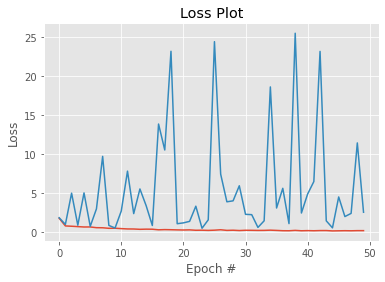

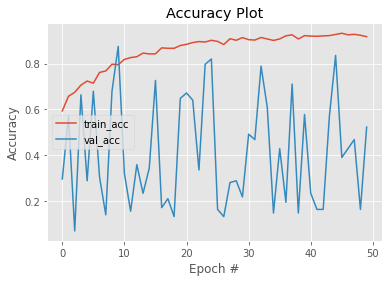

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use("ggplot")

plt.plot(np.arange(0, 50), model_2.history["loss"], label="train_loss")
plt.plot(np.arange(0, 50), model_2.history["val_loss"], label="val_loss")
plt.title("Loss Plot")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.show()

plt.plot(np.arange(0, 50), model_2.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, 50), model_2.history["val_accuracy"], label="val_acc")
plt.title("Accuracy Plot")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import classification_report

pred = model2.predict(test_gen)
predictions = np.argmax(pred, axis = 1)
#labels = (pred > 0.5).astype(np.int)
print(classification_report(test_gen.classes,predictions))

              precision    recall  f1-score   support

           0       1.00      0.86      0.92         7
           1       0.00      0.00      0.00        17
           2       0.71      1.00      0.83        44

    accuracy                           0.74        68
   macro avg       0.57      0.62      0.58        68
weighted avg       0.56      0.74      0.63        68



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
